# Step 3: Data Preprocessing, EDA & Feature Engineering

## Import Libraries

In [2]:
!pip install kagglehub

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Load the dataset

In [4]:
# Download the dataset from kaggle
path = kagglehub.dataset_download("emmanuelfwerr/thyroid-disease-data")
print("Path to dataset files:", path)

100%|██████████| 145k/145k [00:00<00:00, 472kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/emmanuelfwerr/thyroid-disease-data/versions/2


In [5]:
# List files in the downloaded path
files_in_path = os.listdir(path)
print("Files in dataset path:", files_in_path)

Files in dataset path: ['thyroidDF.csv']


In [6]:
df = pd.read_csv(os.path.join(path, 'thyroidDF.csv'))

In [7]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


## Data Cleaning

Handle Duplicates

In [8]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df_before = len(df)
    df = df.drop_duplicates()
    print(f"Removed {df_before - len(df)} duplicate rows")
    print(f"Dataset shape after removing duplicates: {df.shape}")
else:
    print("No duplicates found")

Number of duplicate rows: 0
No duplicates found


Handle Missing Values

In [9]:
missing_summary = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_summary[missing_summary['Missing_Count'] > 0])

Missing Values Summary:
    Feature  Missing_Count  Missing_Percentage
TBG     TBG           8823               96.19
T3       T3           2604               28.39
TSH     TSH            842                9.18
T4U     T4U            809                8.82
FTI     FTI            802                8.74
TT4     TT4            442                4.82
sex     sex            307                3.35


Missing Value Handling Strategy:
1. TBG: DROP (96.19% missing - not informative
2. T3: MEDIAN imputation (28.39% missing)
3. Other lab values (TSH, T4U, FTI, TT4): MEDIAN imputation
4. Sex: MODE imputation (3.35% missing)

In [10]:
# Drop TBG and TBG_measured (>95% missing)
df = df.drop(['TBG', 'TBG_measured'], axis=1)
print(f"Dropped TBG and TBG_measured columns")
print(f"New dataset shape: {df.shape}")

Dropped TBG and TBG_measured columns
New dataset shape: (9172, 29)


In [11]:
# Impute numeric features with median
numeric_cols_to_impute = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
for col in numeric_cols_to_impute:
    if col in df.columns and df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Imputed {col} with median: {median_value:.2f}")

Imputed TSH with median: 1.40
Imputed T3 with median: 1.90
Imputed TT4 with median: 104.00
Imputed T4U with median: 0.96
Imputed FTI with median: 109.00


In [12]:
# Impute sex with mode
if df['sex'].isnull().sum() > 0:
    mode_value = df['sex'].mode()[0]
    df['sex'].fillna(mode_value, inplace=True)
    print(f"Imputed sex with mode: {mode_value}")

Imputed sex with mode: F


In [13]:
# Verify no missing values remain
print(f"Total missing values after imputation: {df.isnull().sum().sum()}")

Total missing values after imputation: 0


Handling Outliers

In [14]:
# Hanlding Outliers in Age column
print(f"Age statistics before cleaning:")
print(f"Min: {df['age'].min()}, Max: {df['age'].max()}")
print(f"Mean: {df['age'].mean():.2f}, Median: {df['age'].median():.2f}")
print(f"Number of ages > 100: {(df['age'] > 100).sum()}")

Age statistics before cleaning:
Min: 1, Max: 65526
Mean: 73.56, Median: 55.00
Number of ages > 100: 4


* Ages > 100 are biologically impossible and likely data entry errors
* We'll remove age at 100 years as this is a reasonable maximum human lifespan

In [15]:
df.loc[df['age'] > 100, 'age'] = df[df['age'] <= 100]['age'].median()

print(f"Age statistics after cleaning:")
print(f"Min: {df['age'].min()}, Max: {df['age'].max()}")
print(f"Mean: {df['age'].mean():.2f}, Median: {df['age'].median():.2f}")

Age statistics after cleaning:
Min: 1, Max: 97
Mean: 52.10, Median: 55.00


In [16]:
# Handle Outliers in Laboratory Test Measurement Values

# Use IQR method for outlier detection and capping
def cap_outliers_iqr(data, column, multiplier=3.0):
    """Cap outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outliers_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()

    if outliers_count > 0:
        data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
        print(f"  {column}: Capped {outliers_count} outliers (bounds: {lower_bound:.2f} to {upper_bound:.2f})")

    return data

In [17]:
# Apply to laboratory values (using 3 IQR for medical data to preserve extreme but valid values)
lab_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
for col in lab_columns:
    if col in df.columns:
        df = cap_outliers_iqr(df, col, multiplier=3.0)

  TSH: Capped 640 outliers (bounds: -5.14 to 8.23)
  T3: Capped 224 outliers (bounds: 0.20 to 3.70)
  TT4: Capped 76 outliers (bounds: -20.00 to 232.00)
  T4U: Capped 155 outliers (bounds: 0.33 to 1.59)
  FTI: Capped 134 outliers (bounds: 2.00 to 219.00)


* The formula 3*IQR is used for outlier removal in order to preserve the extremes but maintaining clinically valid values while removing data entry errors

## Feature Engineering

In [18]:
# Create a copy for feature engineering
df_engineered = df.copy()

Log transformation for highly skewed features (TSH)

In [19]:
# Log transformation for highly skewed features (TSH)
print("Log Transformation for TSH (highly right-skewed):")
df_engineered['TSH_log'] = np.log1p(df_engineered['TSH'])
print(f"Created TSH_log feature")
print(f"Original TSH skewness: {df_engineered['TSH'].skew():.2f}")
print(f"Log-transformed TSH skewness: {df_engineered['TSH_log'].skew():.2f}")

Log Transformation for TSH (highly right-skewed):
Created TSH_log feature
Original TSH skewness: 1.65
Log-transformed TSH skewness: 0.53


Encoding Categorical Features

In [20]:
# Binary encoding for t/f features
binary_features = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds',
                   'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
                   'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre',
                   'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured',
                   'TT4_measured', 'T4U_measured', 'FTI_measured']

for col in binary_features:
    if col in df_engineered.columns:
        df_engineered[col] = df_engineered[col].map({'t': 1, 'f': 0})

print(f"Encoded {len(binary_features)} binary features (t=1, f=0)")

Encoded 19 binary features (t=1, f=0)


In [21]:
# Encode sex
df_engineered['sex'] = df_engineered['sex'].map({'M': 1, 'F': 0})
print("Encoded sex (M=1, F=0)")

Encoded sex (M=1, F=0)


In [22]:
# One-hot encode referral_source
df_engineered = pd.get_dummies(df_engineered, columns=['referral_source'], prefix='referral')
print(f"One-hot encoded referral_source ({df_engineered.filter(like='referral').shape[1]} features)")

One-hot encoded referral_source (6 features)


Binning Continuous Features

In [23]:
# Age binning based on clinical relevance
age_bins = [0, 18, 35, 50, 65, 120]
age_labels = ['child', 'young_adult', 'middle_aged', 'senior', 'elderly']
df_engineered['age_group'] = pd.cut(df_engineered['age'], bins=age_bins, labels=age_labels)

In [24]:
# Convert to numeric for modeling
age_group_map = {'child': 0, 'young_adult': 1, 'middle_aged': 2, 'senior': 3, 'elderly': 4}
df_engineered['age_group'] = df_engineered['age_group'].map(age_group_map)

print("Created age_group feature with 5 categories:")
print(df_engineered['age_group'].value_counts().sort_index())

Created age_group feature with 5 categories:
age_group
0     297
1    1852
2    1850
3    2573
4    2600
Name: count, dtype: int64


In [25]:
# TSH binning based on clinical ranges
# Normal: 0.4-4.0, Low: <0.4, Elevated: 4-10, Very High: >10
tsh_bins = [0, 0.4, 4.0, 10.0, float('inf')]
tsh_labels = ['low', 'normal', 'elevated', 'very_high']
df_engineered['TSH_category'] = pd.cut(df_engineered['TSH'], bins=tsh_bins, labels=tsh_labels)

tsh_category_map = {'low': 0, 'normal': 1, 'elevated': 2, 'very_high': 3}
df_engineered['TSH_category'] = df_engineered['TSH_category'].map(tsh_category_map)

print("\nCreated TSH_category feature based on clinical ranges:")
print(df_engineered['TSH_category'].value_counts().sort_index())


Created TSH_category feature based on clinical ranges:
TSH_category
0    2013
1    5820
2    1339
3       0
Name: count, dtype: int64


Domain-Derived Features (Based on Medical Information)

In [26]:
# Thyroid hormone ratios (clinically relevant)
df_engineered['T3_T4_ratio'] = df_engineered['T3'] / (df_engineered['TT4'] + 1e-5)
print("Created T3_T4_ratio: T3/TT4 ratio (clinical indicator)")

df_engineered['TSH_T4_product'] = df_engineered['TSH'] * df_engineered['TT4']
print("Created TSH_T4_product: TSH*TT4 interaction (thyroid function marker)")

Created T3_T4_ratio: T3/TT4 ratio (clinical indicator)
Created TSH_T4_product: TSH*TT4 interaction (thyroid function marker)


In [27]:
# Composite treatment indicator
df_engineered['any_treatment'] = (
    (df_engineered['on_thyroxine'] == 1) |
    (df_engineered['on_antithyroid_meds'] == 1) |
    (df_engineered['I131_treatment'] == 1)
).astype(int)
print("Created any_treatment: Composite indicator for any thyroid treatment")

Created any_treatment: Composite indicator for any thyroid treatment


In [28]:
# Medical history complexity score
medical_history_features = ['thyroid_surgery', 'I131_treatment', 'goitre', 'tumor',
                            'hypopituitary', 'psych', 'sick', 'lithium']
df_engineered['medical_complexity_score'] = df_engineered[medical_history_features].sum(axis=1)
print("Created medical_complexity_score: Sum of medical history indicators")

Created medical_complexity_score: Sum of medical history indicators


In [29]:
# Symptom query score
symptom_queries = ['query_hypothyroid', 'query_hyperthyroid', 'query_on_thyroxine']
df_engineered['symptom_query_score'] = df_engineered[symptom_queries].sum(axis=1)
print("Created symptom_query_score: Number of thyroid-related queries")

print(f"\nTotal new features created: 8")
print(f"Updated dataset shape: {df_engineered.shape}")

Created symptom_query_score: Number of thyroid-related queries

Total new features created: 8
Updated dataset shape: (9172, 42)


## Applied EDA: Distributions, Relationships, & Clustering tendency

In [30]:
# Create target variable for analysis
df_engineered['target_binary'] = (df_engineered['target'] != '-').astype(int)

### Distribution Analysis

* Numerical features for distribution analysis

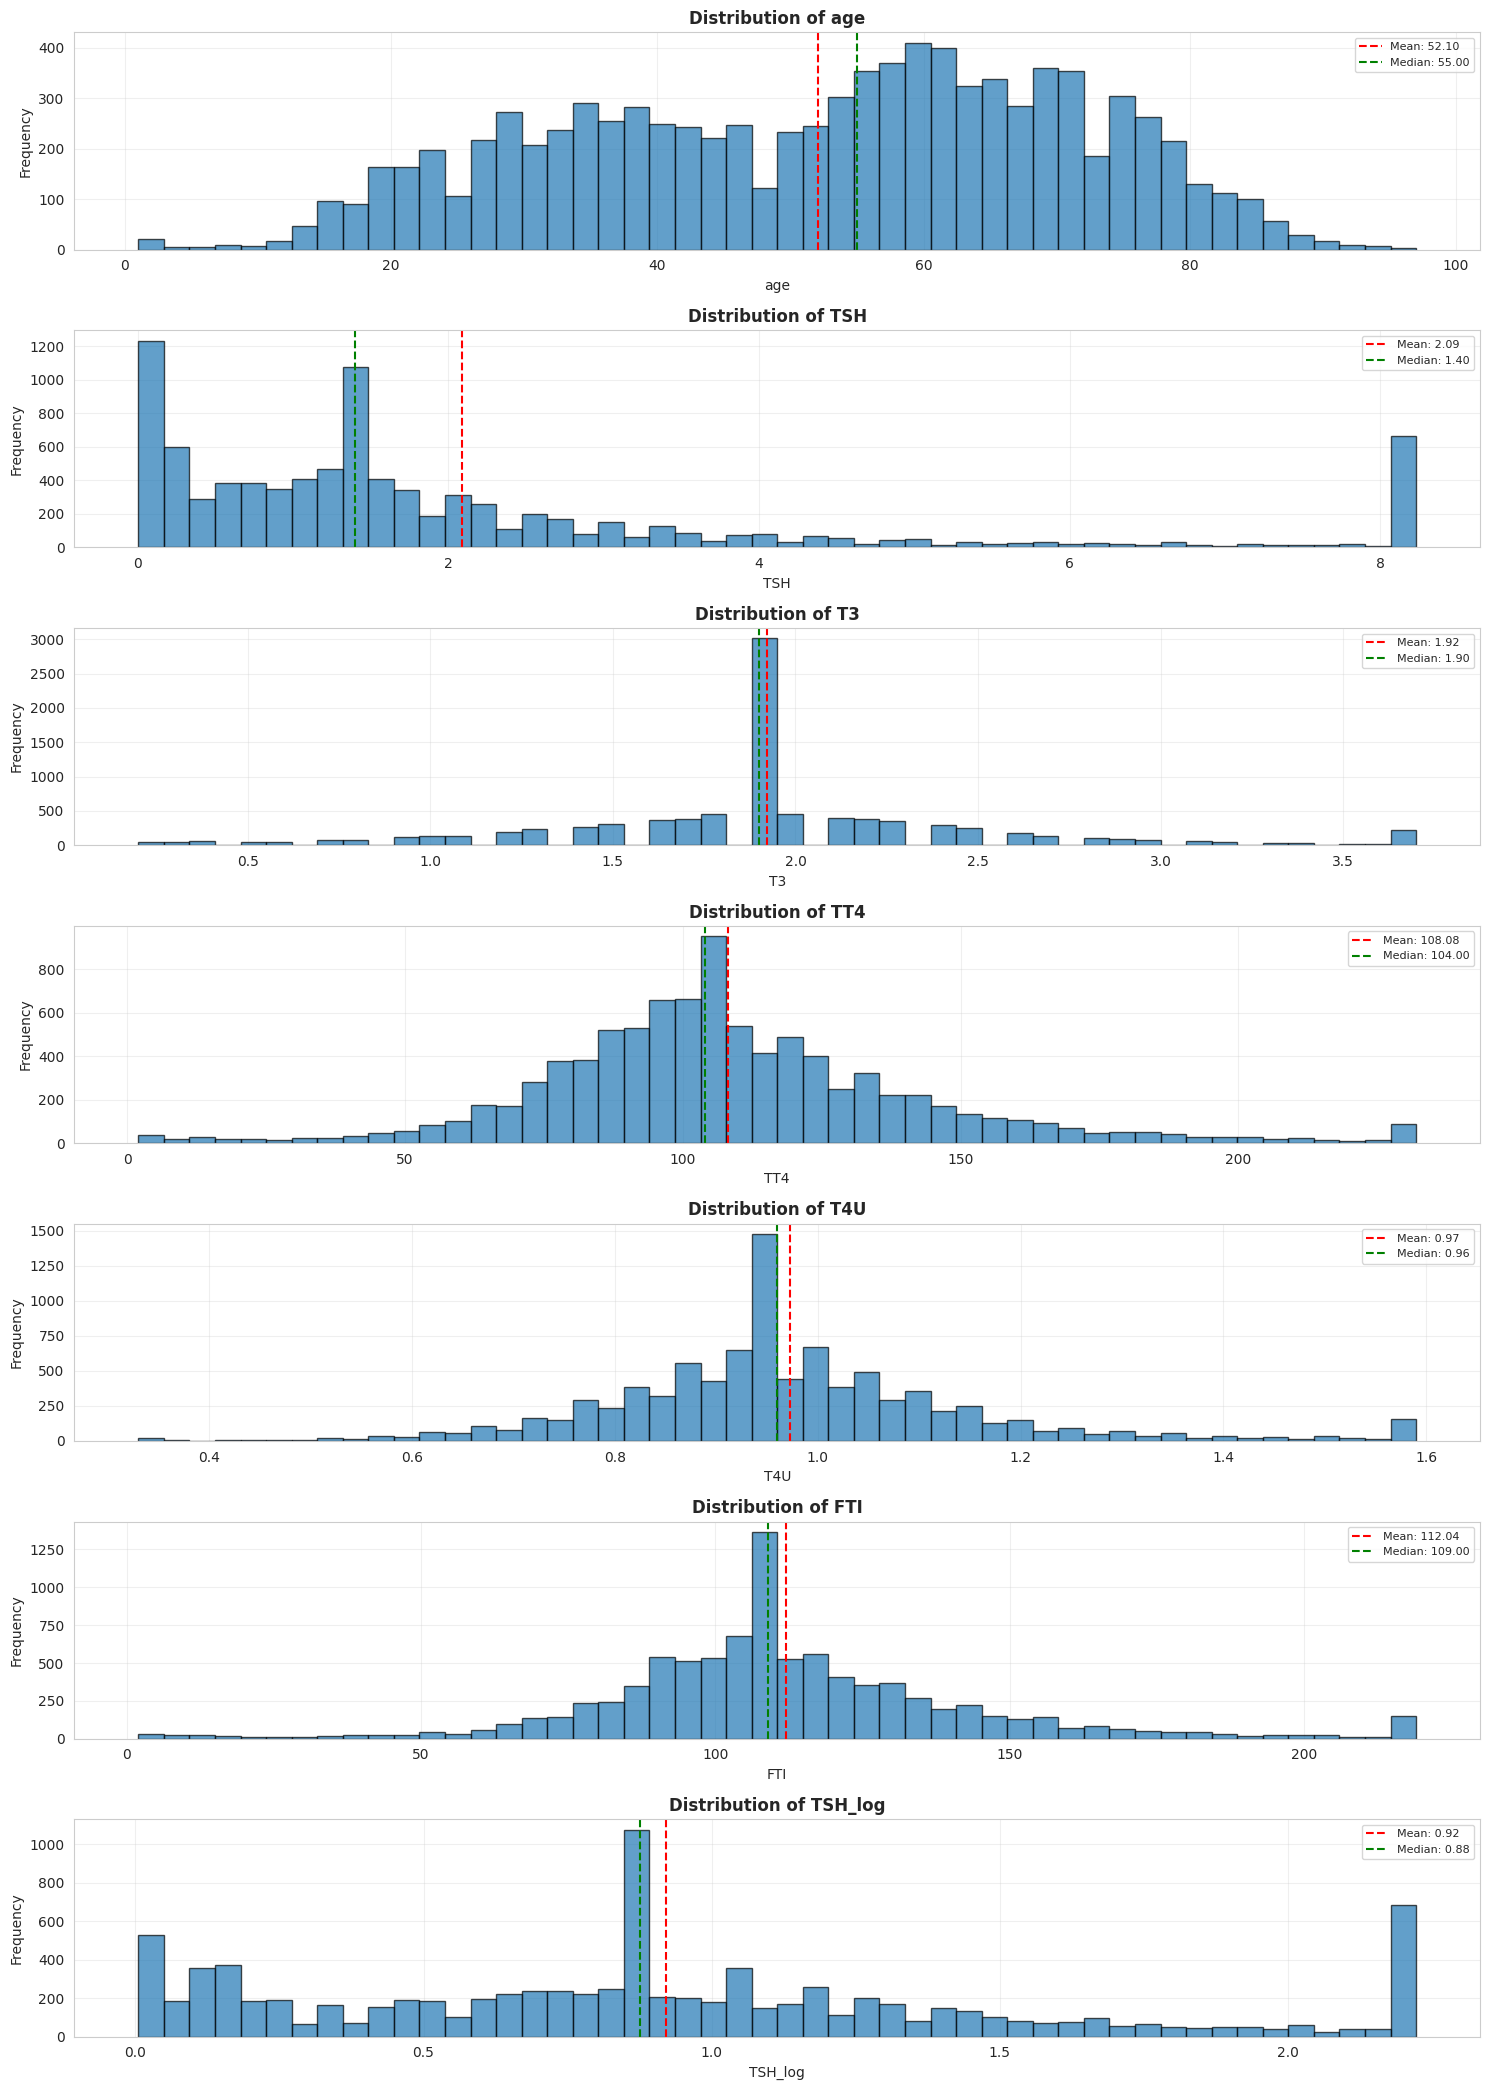

In [31]:
numerical_features = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TSH_log']

# Adjust the number of subplots to match the number of numerical features
# and increase figsize height to accommodate all plots
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(15, 21)) # Changed from 4 to len(numerical_features) and adjusted height
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if col in df_engineered.columns:
        axes[idx].hist(df_engineered[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

        # Add statistics
        mean_val = df_engineered[col].mean()
        median_val = df_engineered[col].median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
        axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

* Distribution by target class

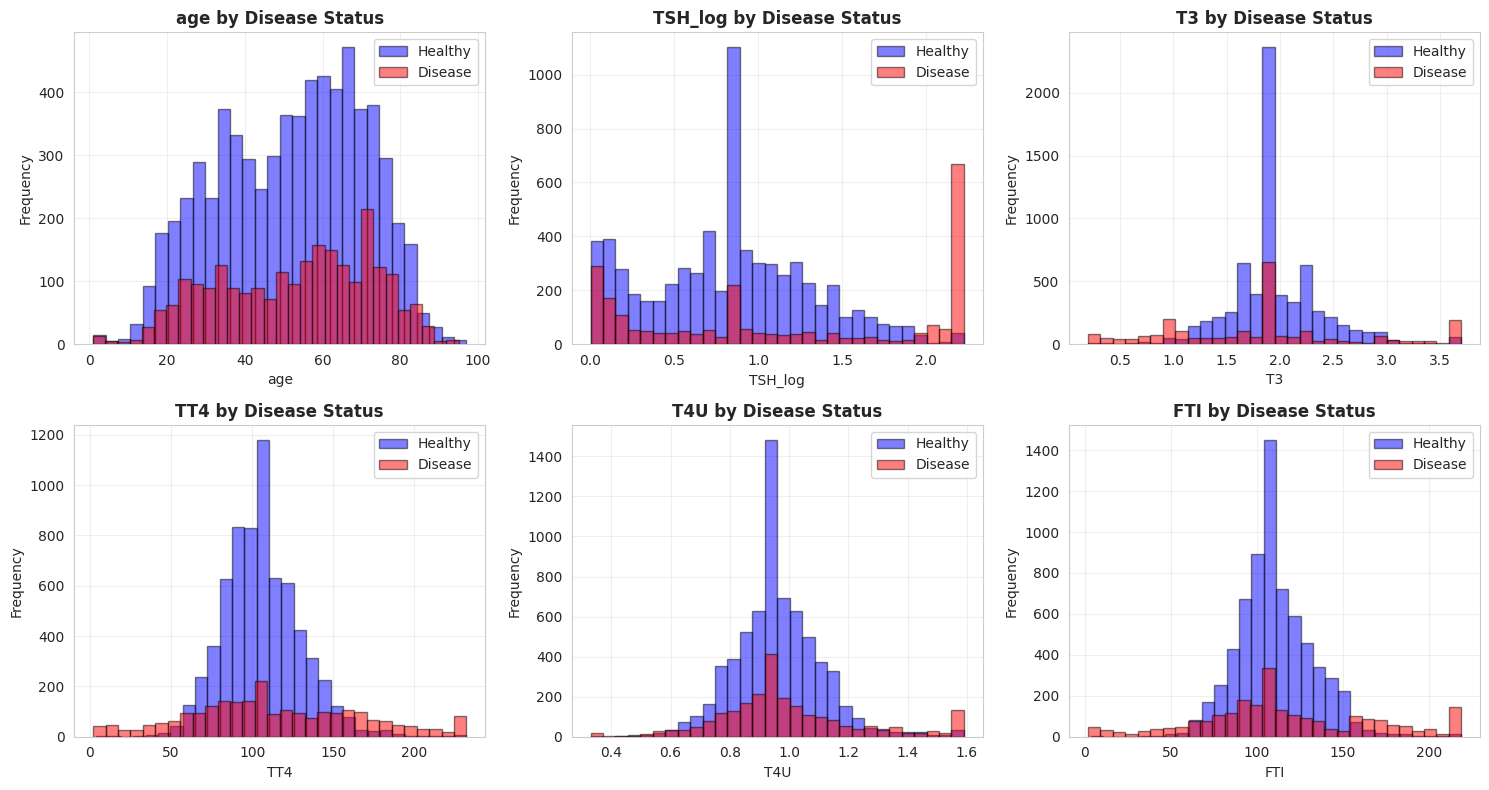

In [32]:
# Distribution by target class
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

key_features = ['age', 'TSH_log', 'T3', 'TT4', 'T4U', 'FTI']
for idx, col in enumerate(key_features):
    if col in df_engineered.columns:
        healthy = df_engineered[df_engineered['target_binary'] == 0][col].dropna()
        disease = df_engineered[df_engineered['target_binary'] == 1][col].dropna()

        axes[idx].hist(healthy, bins=30, alpha=0.5, label='Healthy', color='blue', edgecolor='black')
        axes[idx].hist(disease, bins=30, alpha=0.5, label='Disease', color='red', edgecolor='black')
        axes[idx].set_title(f'{col} by Disease Status', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Relationship Analysis - Correlation Matrix

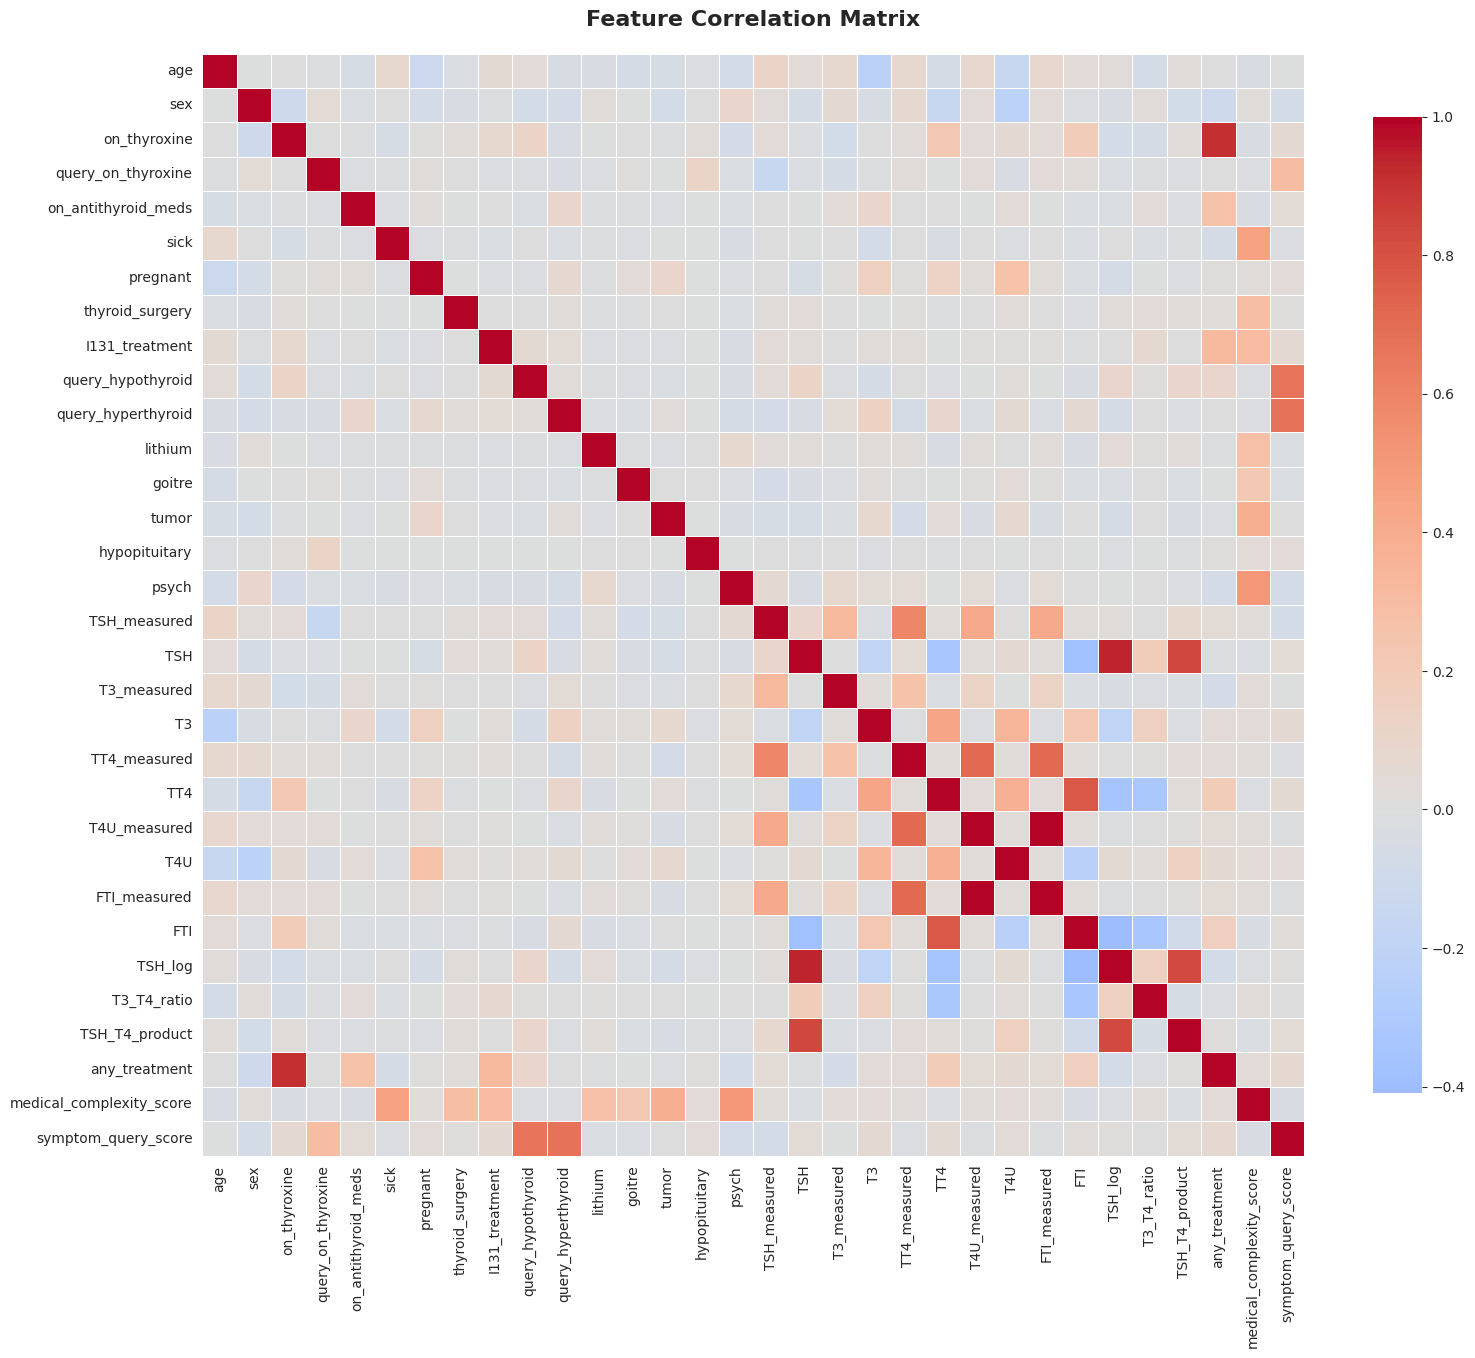


Highly Correlated Feature Pairs (|r| > 0.8):
   Feature 1      Feature 2  Correlation
on_thyroxine  any_treatment     0.909454
         TSH        TSH_log     0.944963
         TSH TSH_T4_product     0.837057
T4U_measured   FTI_measured     0.993887
     TSH_log TSH_T4_product     0.827953


In [33]:
# Relationship Analysis - Correlation Matrix

# Select numerical columns for correlation
numerical_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
# Remove patient_id and target
numerical_cols = [col for col in numerical_cols if col not in ['patient_id', 'target_binary']]

correlation_matrix = df_engineered[numerical_cols].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated features
print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
else:
    print("No highly correlated pairs found")

### Scatter Plots - Key Relationships


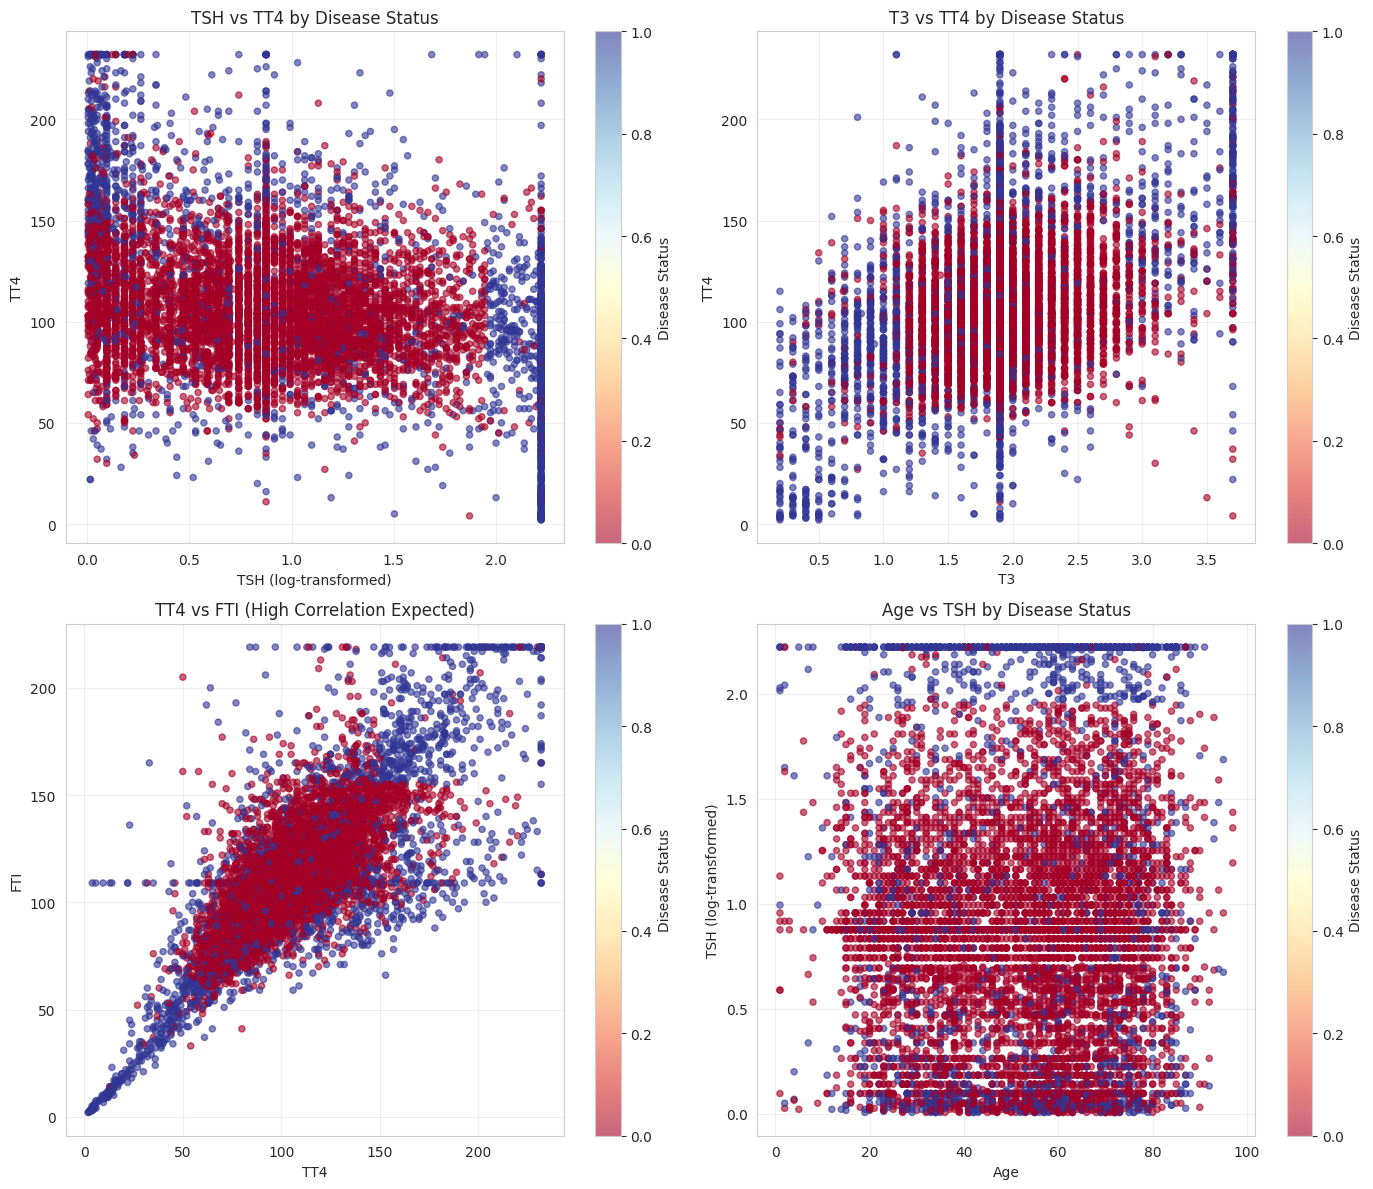

In [34]:
# Create scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# TSH vs T4 (inverse relationship expected)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(df_engineered['TSH_log'], df_engineered['TT4'],
                       c=df_engineered['target_binary'], cmap='RdYlBu', alpha=0.6, s=20)
ax1.set_xlabel('TSH (log-transformed)')
ax1.set_ylabel('TT4')
ax1.set_title('TSH vs TT4 by Disease Status')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Disease Status')

# T3 vs TT4 (positive correlation expected)
ax2 = axes[0, 1]
scatter2 = ax2.scatter(df_engineered['T3'], df_engineered['TT4'],
                       c=df_engineered['target_binary'], cmap='RdYlBu', alpha=0.6, s=20)
ax2.set_xlabel('T3')
ax2.set_ylabel('TT4')
ax2.set_title('T3 vs TT4 by Disease Status')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Disease Status')

# TT4 vs FTI (high correlation expected)
ax3 = axes[1, 0]
scatter3 = ax3.scatter(df_engineered['TT4'], df_engineered['FTI'],
                       c=df_engineered['target_binary'], cmap='RdYlBu', alpha=0.6, s=20)
ax3.set_xlabel('TT4')
ax3.set_ylabel('FTI')
ax3.set_title('TT4 vs FTI (High Correlation Expected)')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Disease Status')

# Age vs TSH
ax4 = axes[1, 1]
scatter4 = ax4.scatter(df_engineered['age'], df_engineered['TSH_log'],
                       c=df_engineered['target_binary'], cmap='RdYlBu', alpha=0.6, s=20)
ax4.set_xlabel('Age')
ax4.set_ylabel('TSH (log-transformed)')
ax4.set_title('Age vs TSH by Disease Status')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=ax4, label='Disease Status')

plt.tight_layout()
plt.show()


### Clustering Tendency Analysis

In [35]:
# Prepare data for clustering analysis
# Select only numeric features and drop target
features_for_clustering = df_engineered[numerical_cols].copy()

# Standardize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# K-means clustering with different k values
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 11)

print("\nEvaluating clustering tendency:")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)

    sil_score = silhouette_score(features_scaled, cluster_labels)
    db_score = davies_bouldin_score(features_scaled, cluster_labels)

    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)

    print(f"k={k}: Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")


Evaluating clustering tendency:
k=2: Silhouette=0.261, Davies-Bouldin=1.647
k=3: Silhouette=0.232, Davies-Bouldin=2.153
k=4: Silhouette=0.193, Davies-Bouldin=2.041
k=5: Silhouette=0.207, Davies-Bouldin=1.852
k=6: Silhouette=0.216, Davies-Bouldin=1.696
k=7: Silhouette=0.215, Davies-Bouldin=1.737
k=8: Silhouette=0.226, Davies-Bouldin=1.707
k=9: Silhouette=0.218, Davies-Bouldin=1.806
k=10: Silhouette=0.228, Davies-Bouldin=1.473


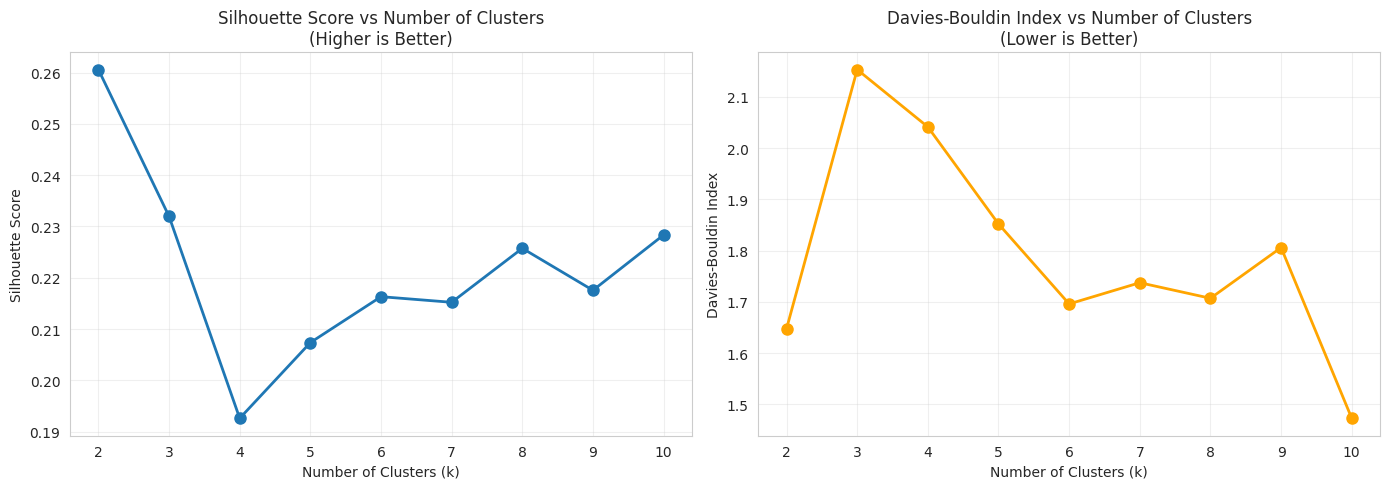


Optimal number of clusters based on Silhouette Score: 2


In [36]:
# Plot clustering metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs Number of Clusters\n(Higher is Better)')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, davies_bouldin_scores, marker='o', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Davies-Bouldin Index')
ax2.set_title('Davies-Bouldin Index vs Number of Clusters\n(Lower is Better)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")

## Feature Importance and Explainability

In [37]:
# Prepare features and target
X = df_engineered[numerical_cols].copy()
y = df_engineered['target_binary'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Feature matrix shape: (9172, 32)
Target variable shape: (9172,)


Random Forest Feature Importance


Top 15 Most Important Features:
       Feature  Importance
            T3    0.169782
       TSH_log    0.143373
           FTI    0.139629
           TT4    0.131856
           TSH    0.128109
TSH_T4_product    0.081175
   T3_T4_ratio    0.080116
           T4U    0.059290
           age    0.014618
   T3_measured    0.008241
      pregnant    0.007756
 any_treatment    0.004327
  on_thyroxine    0.003994
           sex    0.003005
  TSH_measured    0.002771


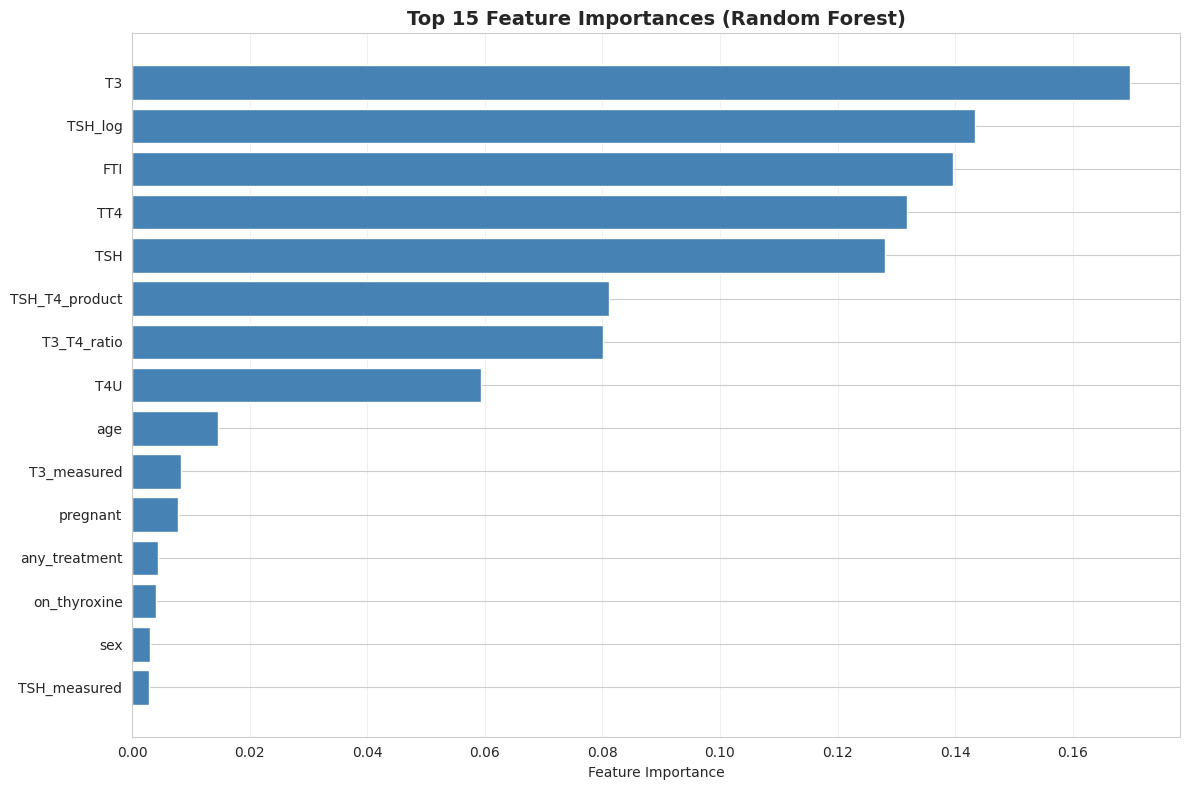

In [38]:
# Train Random Forest for feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)
rf_model.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importances.head(15).to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
top_15_features = feature_importances.head(15)
ax.barh(range(len(top_15_features)), top_15_features['Importance'], color='steelblue')
ax.set_yticks(range(len(top_15_features)))
ax.set_yticklabels(top_15_features['Feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Statistical Feature Importance (F-statistic)

In [39]:
# Calculate F-statistics
f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X, y)

f_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': f_selector.scores_,
    'P_Value': f_selector.pvalues_
}).sort_values('F_Score', ascending=False)

print("Top 15 Features by F-Score:")
print(f_scores.head(15).to_string(index=False))

Top 15 Features by F-Score:
            Feature     F_Score       P_Value
                TSH 1494.842143 4.359818e-303
     TSH_T4_product  773.713319 1.505791e-163
            TSH_log  547.784525 1.027843e-117
           pregnant  118.936123  1.595493e-27
                TT4  110.061856  1.325872e-25
                 T3   93.857513  4.326053e-22
                sex   72.991609  1.510351e-17
                T4U   57.493710  3.720495e-14
              psych   47.589037  5.604083e-12
                FTI   46.113481  1.185300e-11
       on_thyroxine   45.997096  1.257475e-11
      any_treatment   41.818703  1.052526e-10
symptom_query_score   35.598316  2.514801e-09
       TSH_measured   30.850409  2.864876e-08
  query_hypothyroid   27.817058  1.363858e-07


Mutual Information

In [40]:
# Calculate mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 15 Features by Mutual Information:")
print(mi_scores_df.head(15).to_string(index=False))

Top 15 Features by Mutual Information:
            Feature  MI_Score
            TSH_log  0.137176
                TSH  0.133835
     TSH_T4_product  0.133787
        T3_T4_ratio  0.133676
                TT4  0.103430
                 T3  0.103085
                FTI  0.102762
                T4U  0.028015
symptom_query_score  0.009906
              psych  0.006673
       on_thyroxine  0.006102
                sex  0.005563
             goitre  0.005526
        T3_measured  0.004609
      hypopituitary  0.003893


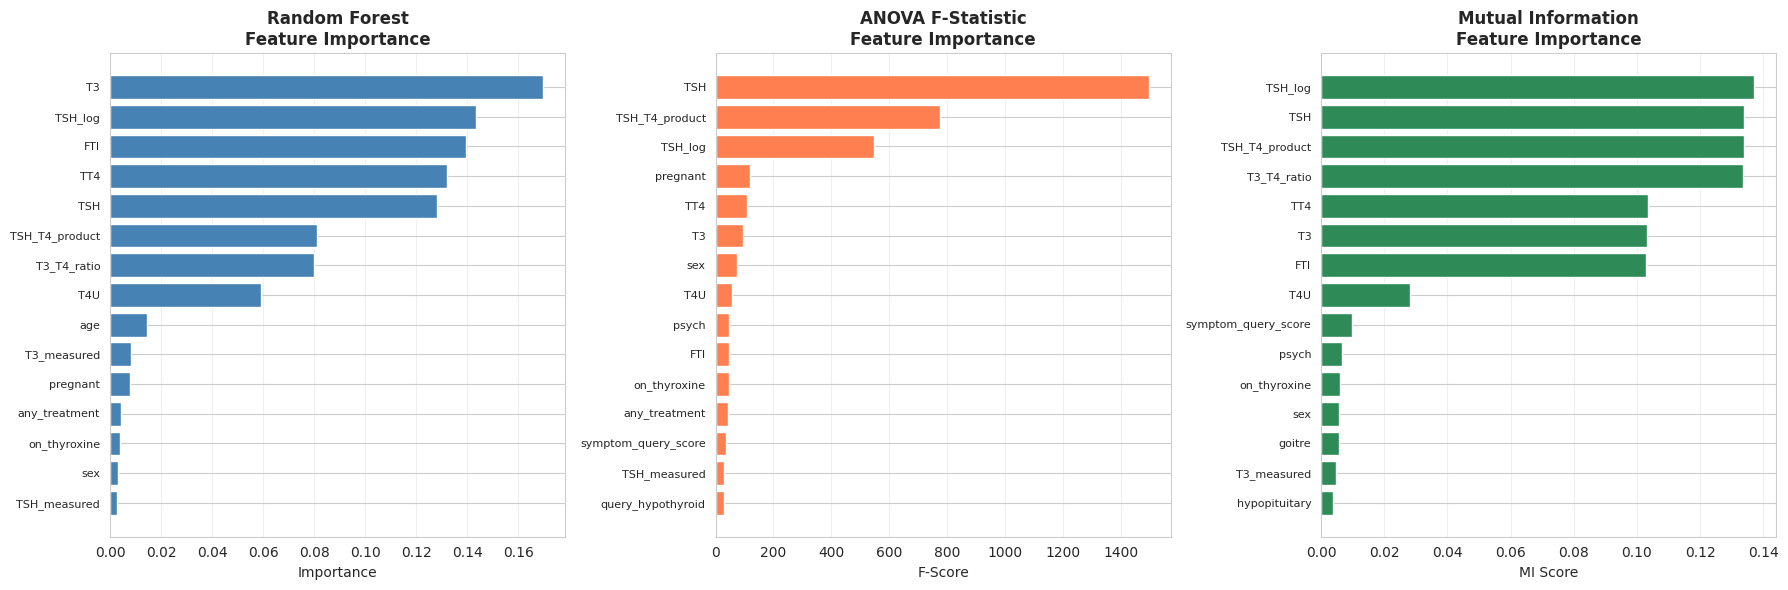

In [41]:
# Plot comparison of importance metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RF Importance
top_15_rf = feature_importances.head(15)
axes[0].barh(range(len(top_15_rf)), top_15_rf['Importance'], color='steelblue')
axes[0].set_yticks(range(len(top_15_rf)))
axes[0].set_yticklabels(top_15_rf['Feature'], fontsize=8)
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest\nFeature Importance', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# F-Score
top_15_f = f_scores.head(15)
axes[1].barh(range(len(top_15_f)), top_15_f['F_Score'], color='coral')
axes[1].set_yticks(range(len(top_15_f)))
axes[1].set_yticklabels(top_15_f['Feature'], fontsize=8)
axes[1].set_xlabel('F-Score')
axes[1].set_title('ANOVA F-Statistic\nFeature Importance', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Mutual Information
top_15_mi = mi_scores_df.head(15)
axes[2].barh(range(len(top_15_mi)), top_15_mi['MI_Score'], color='seagreen')
axes[2].set_yticks(range(len(top_15_mi)))
axes[2].set_yticklabels(top_15_mi['Feature'], fontsize=8)
axes[2].set_xlabel('MI Score')
axes[2].set_title('Mutual Information\nFeature Importance', fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## Feature Selection

### Filter Method: Correlation-Based Feature Selection

In [42]:
# Remove one feature from highly correlated pairs (|r| > 0.9)
correlation_matrix = X.corr()
features_to_remove = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            # Keep the feature with higher variance
            var1 = X[correlation_matrix.columns[i]].var()
            var2 = X[correlation_matrix.columns[j]].var()

            if var1 > var2:
                features_to_remove.add(correlation_matrix.columns[j])
            else:
                features_to_remove.add(correlation_matrix.columns[i])

print(f"Features to remove due to high correlation (|r| > 0.9): {len(features_to_remove)}")
if features_to_remove:
    print(f"Removed features: {', '.join(features_to_remove)}")

X_filtered = X.drop(columns=list(features_to_remove))
print(f"Shape after correlation filtering: {X_filtered.shape}")

Features to remove due to high correlation (|r| > 0.9): 3
Removed features: FTI_measured, on_thyroxine, TSH_log
Shape after correlation filtering: (9172, 29)


### Wrapper Method: Recursive Feature Elimination (RFE)

In [43]:
# Wrapper Method: Recursive Feature Elimination (RFE)

# Use RFE with Random Forest
n_features_to_select = min(20, X_filtered.shape[1])
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10),
                   n_features_to_select=n_features_to_select,
                   step=1)

rfe_selector.fit(X_filtered, y)

# Get selected features
rfe_selected_features = X_filtered.columns[rfe_selector.support_].tolist()
print(f"RFE Selected {len(rfe_selected_features)} features:")
for i, feat in enumerate(rfe_selected_features, 1):
    print(f"  {i}. {feat}")

RFE Selected 20 features:
  1. age
  2. sex
  3. pregnant
  4. thyroid_surgery
  5. query_hypothyroid
  6. query_hyperthyroid
  7. TSH_measured
  8. TSH
  9. T3_measured
  10. T3
  11. TT4_measured
  12. TT4
  13. T4U_measured
  14. T4U
  15. FTI
  16. T3_T4_ratio
  17. TSH_T4_product
  18. any_treatment
  19. medical_complexity_score
  20. symptom_query_score


### Embedded Method: Feature Selection using Lasso

In [44]:
# Embedded Method: Feature Selection using Lasso

# Get top features from each method
top_rf_features = set(feature_importances.head(20)['Feature'].tolist())
top_f_features = set(f_scores.head(20)['Feature'].tolist())
top_mi_features = set(mi_scores_df.head(20)['Feature'].tolist())

# Features selected by at least 2 methods
common_features = []
for feat in X_filtered.columns:
    count = sum([
        feat in top_rf_features,
        feat in top_f_features,
        feat in top_mi_features
    ])
    if count >= 2:
        common_features.append(feat)

print(f"Features selected by at least 2 methods: {len(common_features)}")
print("Selected features:")
for i, feat in enumerate(common_features, 1):
    methods = []
    if feat in top_rf_features: methods.append('RF')
    if feat in top_f_features: methods.append('F-stat')
    if feat in top_mi_features: methods.append('MI')
    print(f"  {i}. {feat} ({', '.join(methods)})")



Features selected by at least 2 methods: 18
Selected features:
  1. sex (RF, F-stat, MI)
  2. pregnant (RF, F-stat, MI)
  3. query_hyperthyroid (F-stat, MI)
  4. goitre (F-stat, MI)
  5. psych (F-stat, MI)
  6. TSH_measured (RF, F-stat)
  7. TSH (RF, F-stat, MI)
  8. T3_measured (RF, F-stat, MI)
  9. T3 (RF, F-stat, MI)
  10. TT4 (RF, F-stat, MI)
  11. T4U_measured (RF, MI)
  12. T4U (RF, F-stat, MI)
  13. FTI (RF, F-stat, MI)
  14. T3_T4_ratio (RF, F-stat, MI)
  15. TSH_T4_product (RF, F-stat, MI)
  16. any_treatment (RF, F-stat)
  17. medical_complexity_score (RF, F-stat)
  18. symptom_query_score (RF, F-stat, MI)


In [45]:
# Final selected features for modeling
X_selected = X_filtered[common_features].copy()
print(f"Final feature set shape: {X_selected.shape}")

Final feature set shape: (9172, 18)


## Dimensionality Reduction

### PCA (Principal Component Analysis)


Number of components explaining 95% variance: 14
Total variance explained by 14 components: 0.9529

Variance explained by first 14 components:
  PC1: 0.1421 (Cumulative: 0.1421)
  PC2: 0.1094 (Cumulative: 0.2515)
  PC3: 0.0971 (Cumulative: 0.3486)
  PC4: 0.0880 (Cumulative: 0.4367)
  PC5: 0.0849 (Cumulative: 0.5216)
  PC6: 0.0752 (Cumulative: 0.5968)
  PC7: 0.0596 (Cumulative: 0.6563)
  PC8: 0.0568 (Cumulative: 0.7131)
  PC9: 0.0529 (Cumulative: 0.7660)
  PC10: 0.0489 (Cumulative: 0.8150)
  PC11: 0.0457 (Cumulative: 0.8607)
  PC12: 0.0402 (Cumulative: 0.9009)
  PC13: 0.0282 (Cumulative: 0.9291)
  PC14: 0.0238 (Cumulative: 0.9529)


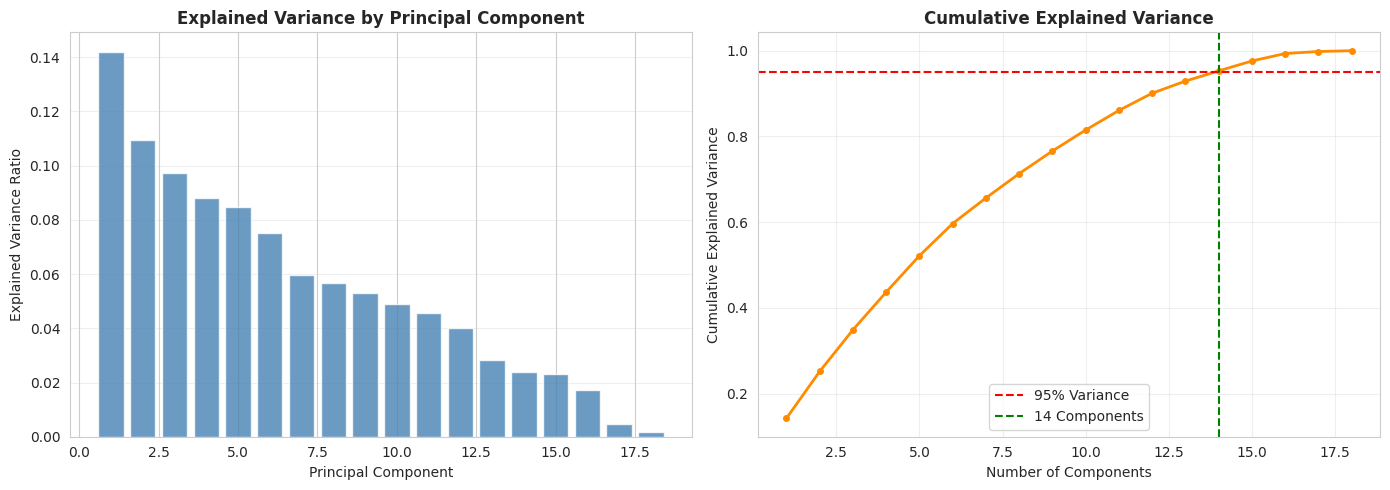

In [46]:

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components_95}")
print(f"Total variance explained by {n_components_95} components: {cumulative_variance[n_components_95-1]:.4f}")

# Print first 10 components variance
print("\nVariance explained by first 14 components:")
for i in range(min(14, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} "
          f"(Cumulative: {cumulative_variance[i]:.4f})")

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
ax1.bar(range(1, min(21, len(pca.explained_variance_ratio_)+1)),
        pca.explained_variance_ratio_[:20], color='steelblue', alpha=0.8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Principal Component', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance,
         marker='o', linewidth=2, markersize=4, color='darkorange')
ax2.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
ax2.axvline(x=n_components_95, color='green', linestyle='--',
            label=f'{n_components_95} Components')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### PCA Visualization (2D)

Variance explained by 2 components: 0.2515


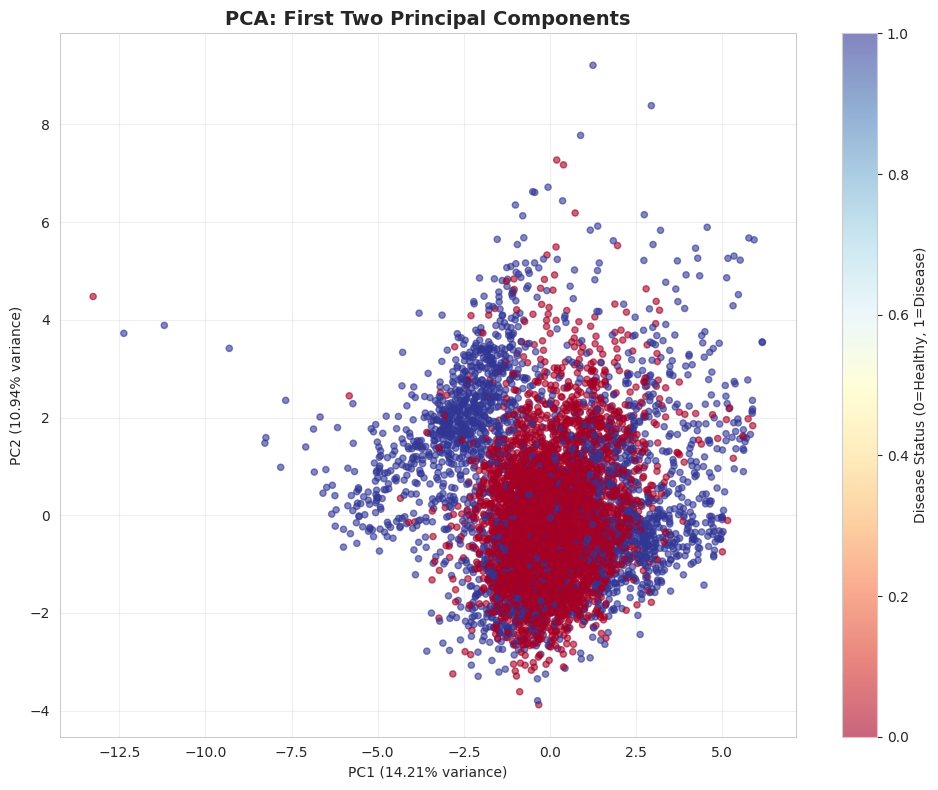

In [47]:
# Reduce to 2 components for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"Variance explained by 2 components: {sum(pca_2d.explained_variance_ratio_):.4f}")

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                     c=y, cmap='RdYlBu', alpha=0.6, s=20)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
ax.set_title('PCA: First Two Principal Components', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Disease Status (0=Healthy, 1=Disease)')

plt.tight_layout()
plt.show()



### t-SNE Visualization

t-SNE completed on 5000 samples


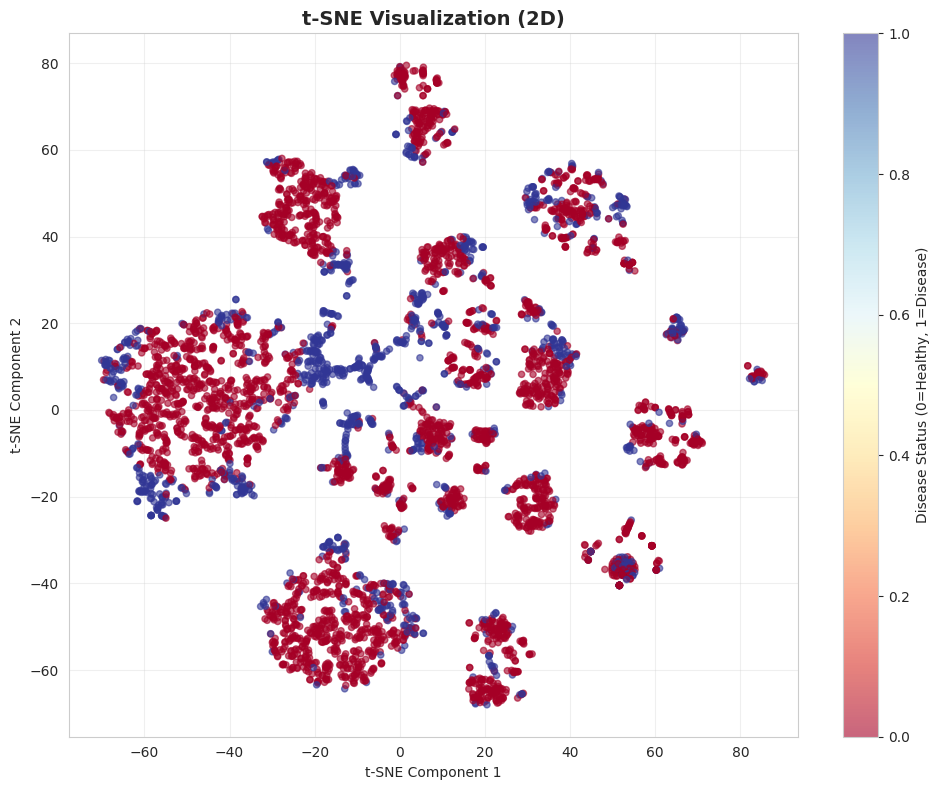

In [48]:
# Apply t-SNE (use subset for computational efficiency)
n_samples_tsne = min(5000, len(X_scaled))
indices = np.random.choice(len(X_scaled), n_samples_tsne, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled[indices])

print(f"t-SNE completed on {n_samples_tsne} samples")

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                     c=y.iloc[indices], cmap='RdYlBu', alpha=0.6, s=20)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('t-SNE Visualization (2D)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Disease Status (0=Healthy, 1=Disease)')

plt.tight_layout()
plt.show()

## Save Processed Data

In [49]:
# Save different versions of the processed data
# 1. Fully cleaned and engineered dataset
df_engineered.to_csv('./data/thyroid_cleaned_engineered.csv', index=False)
print("Saved: ./data/thyroid_cleaned_engineered.csv")
print(f"Shape: {df_engineered.shape}")

# 2. Selected features dataset
X_selected_with_target = X_selected.copy()
X_selected_with_target['target'] = df_engineered['target']
X_selected_with_target['target_binary'] = df_engineered['target_binary']
X_selected_with_target['patient_id'] = df_engineered['patient_id']
X_selected_with_target.to_csv('./data/thyroid_selected_features.csv', index=False)
print("Saved: ./data/thyroid_selected_features.csv")
print(f"Shape: {X_selected_with_target.shape}")

# 3. PCA-transformed dataset (95% variance)
pca_optimal = PCA(n_components=n_components_95)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca_optimal,columns=[f'PC{i+1}' for i in range(n_components_95)])
pca_df['target'] = df_engineered['target'].values
pca_df['target_binary'] = df_engineered['target_binary'].values
pca_df['patient_id'] = df_engineered['patient_id'].values
pca_df.to_csv('./data/thyroid_pca_transformed.csv', index=False)
print("Saved: ./data/thyroid_pca_transformed.csv")
print(f"Shape: {pca_df.shape}")
print(f"Components: {n_components_95} (explaining {cumulative_variance[n_components_95-1]:.2%} variance)")

Saved: thyroid_cleaned_engineered.csv
Shape: (9172, 43)
Saved: thyroid_selected_features.csv
Shape: (9172, 21)
Saved: thyroid_pca_transformed.csv
Shape: (9172, 17)
Components: 14 (explaining 95.29% variance)
